<h1 align=center><font size = 7>Email Spam Classificator</font></h1>

As a mail user, you have surely heard the term spam on more than one occasion. You may have received spam in your inbox, or you had to check the spam folder to find an email that you were waiting for, and there you have found hundreds of emails that you did not know.

All this is due to the operation of the spam filter of your email provider, which analyzes all the emails received and makes the decision about it.

In this notebook, our goal will be to create a model that allows emails to be classified as spam based on the words they contain. To do this, we will start with a dataset of more than 5000 examples, and we will create a model based on the logistic regression. Then, we will measure its accuracy and its behavior with false positives and negatives.

__IMPORTANT NOTE__: This notebook was made by __Alejandro Velázquez Portas__ (<a href="https://www.linkedin.com/in/alexvelazquezp/">LinkedIn profile</a>). Take this into account when reproducing or citing its content.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn import metrics
import time
import itertools

# 1. Data import

Let's strat reading our original input file and creating the dataset:

In [2]:
df = pd.read_csv('emails.csv')
df.head()

,Email No.,the,to,ect,and,for,of,a,you,hou,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,Email 1,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Email 2,8,13,24,6,6,2,102,1,27,...,0,0,0,0,0,0,0,1,0,0
2,Email 3,0,0,1,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Email 4,0,5,22,0,5,1,51,2,10,...,0,0,0,0,0,0,0,0,0,0
4,Email 5,7,6,17,1,5,2,57,0,9,...,0,0,0,0,0,0,0,1,0,0


The first step will be understand the dataset. If we check the dataframe size, the values will be the following:

In [3]:
df.shape

(5172, 3002)

The dataframe contains 5172 rows, which is, 5172 example emails. Meanwhile, the number of columns is 3002. How can it be so high?

The dataframe is structured so that each column is a word, and each row records the number of times it appears in the email. For example, if a column named _'python'_ has the value 2 for an email, it means that the word _'python'_ appeared 2 times in the original email.

Following the data wrangling process, let's check if there is any null value:

In [4]:
df.isnull().values.sum()

0

Without null values, we can delete the _'Email No.'_ column because it only contains a correlative number for each email:

In [5]:
df.drop(columns=['Email No.'], inplace=True)

# 2. Data analysis 

Let's start checking how many spam emails there are in our dataframe:

In [6]:
spam_num = df['Prediction'][df['Prediction'] == 1].count()
nospam_num = df['Prediction'][df['Prediction'] == 0].count()
print('From a total of {} emails, there are {} spam and {} no spam emails'.format(len(df), spam_num, nospam_num))

From a total of 5172 emails, there are 1500 spam and 3672 no spam emails


We can also check it in a figure:

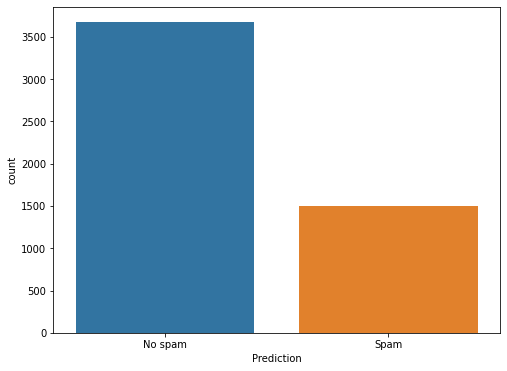

In [7]:
plt.figure(figsize=(8,6))
ax = sns.countplot(x='Prediction', data=df)
ax.set_xticklabels(['No spam','Spam'])
plt.show()

If we try to obtain the 5 most frequent values in a spam mail, in the count we will obtain only letters, which will not provide any information as it is also possible that they appear in valid emails.

In [8]:
most_freq = df[df['Prediction'] == 1].sum()
most_freq = most_freq.to_frame(name='count')
most_freq.sort_values('count', ascending=False, axis=0, inplace=True)
most_freq.head(5)

,count
e,151062
t,109878
a,105425
o,103997
i,100761


If we try to obtain the 5 most frequent values in a spam mail, in the count we will obtain only letters, which will not provide any information as it is also possible that they appear in valid emails.

We may be tempted to see which words vary the most from spam emails to valid emails, and thus be able to draw conclusions about what the differences are. Let's try it:

In [9]:
#Group the values by prediction type
most_freq = df.groupby('Prediction').sum().T
most_freq.rename(columns={0: 'No spam', 1: 'Spam'}, inplace=True)
#Normalize the number of values according to the number of no spam or spam emails
most_freq['No spam'] = most_freq['No spam'] / nospam_num
most_freq['Spam'] = most_freq['Spam'] / spam_num
#Calculates a new column with the difference between spam and no spam average
most_freq = most_freq.assign(Difference=pd.Series(most_freq['Spam']-most_freq['No spam']))
#Sort difference descending. Higher values will be the most use only in spam mails
most_freq.sort_values('Difference', ascending=False, axis=0, inplace=True)
#Print top10
most_freq.head(5)

Prediction,No spam,Spam,Difference
i,37.150327,67.174000,30.023673
e,78.294935,100.708000,22.413065
a,49.485566,70.283333,20.797767
r,39.550381,59.763333,20.212952
o,49.284586,69.331333,20.046747


The problem is the same again. The words that have varied the most are only letters, and do not provide any information. It is clear that the only possibility is through a classification model such as the logistic regression, with no possibility of achieving it through exploratory data analysis.

If you are curious about certain words that are usually present in some spam emails, the answer is yes, they are more frequent than in valid emails:

In [10]:
most_freq[(most_freq.index == 'sex') | 
          (most_freq.index == 'drug') | 
          (most_freq.index == 'love') |
          (most_freq.index == 'cheap') |
          (most_freq.index == 'viagra') |
          (most_freq.index == 'money') |
          (most_freq.index == 'car')
          ]

Prediction,No spam,Spam,Difference
car,0.240741,0.472000,0.231259
money,0.016340,0.203333,0.186993
viagra,0.000000,0.130667,0.130667
sex,0.001089,0.115333,0.114244
drug,0.000000,0.108000,0.108000
cheap,0.000545,0.082667,0.082122
love,0.037582,0.073333,0.035752


Continuing with the model creation tasks, let's create variables x and y for our model

In [11]:
df_x = df.copy()
df_x.drop(columns=['Prediction'], inplace=True)
x = np.asarray(df_x)
df_y = df[['Prediction']]
y = np.asarray(df_y)

We will divide our data for training (80%) and testing (20%):

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)

# 3. Model

Now, we can create our model based on logistic regression, fit it using the train data and make a prediction using the test data. This prediction will be compared with the real data, obtaining the accuracy.

Futhermore, we will record the fit and the predict time, to find out if our model can be used as a real-time solution

In [13]:
ini = time.time()
lr = LogisticRegression(C=0.1, solver='liblinear').fit(x_train, y_train.ravel())
end = time.time()
print('The execution time for fitting was {:.3f} seconds'.format(end - ini))
ini = time.time()
yhat = lr.predict(x_test)
end = time.time()
print('The execution time for predicting was {:.3f} seconds, {:.5f}s per email'.format(end - ini, (end - ini)/len(x_test)))
acc_score = metrics.accuracy_score(y_test,yhat)
print("The model's accuracy was {:.3f}%".format(acc_score*100))

The execution time for fitting was 0.914 seconds
The execution time for predicting was 0.019 seconds, 0.00002s per email
The model's accuracy was 97.585%


The accuracy was excelent, and a time of less than millisecond is suitable for a real use.

Let's check the confusion matrix to know how our model works with false positives and negatives:

In [14]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

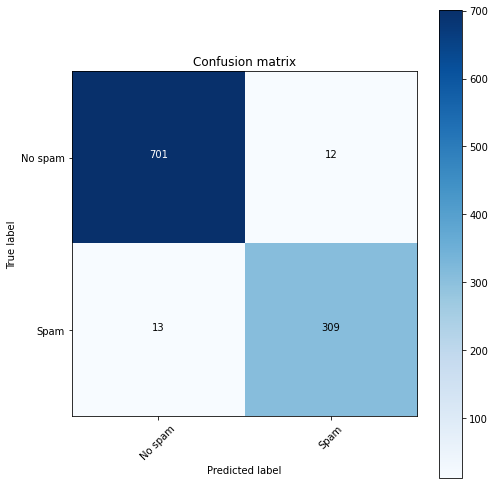

In [15]:
c_matrix = confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)
plt.figure(figsize=(7,7))
plot_confusion_matrix(c_matrix, classes=['No spam','Spam'],normalize= False,  title='Confusion matrix')

What does the above figure mean mean? From a total of 1035 emails, our model correctly classified 309 as spam and 701 as no spam. In the other side, our model classified 12 emails as spam when they were actually proper mail (1,16%) and allowed 13 spam emails to reach our inbox without being filtered (1,26%).

The sum of false positivies and negatives, plus the model's accuracy, is the total of our test data (1,16% + 1,26% + 97,58% = 100%).

Finally, we can plot the ROC curve and calculate the AUC, which will also be an indicator of the model's performance. Values between 0.7 and 0.8 can be considered as good, between 0.8 and 0.9 as excellent, and the AUC values over 0.9 will be outstanding.

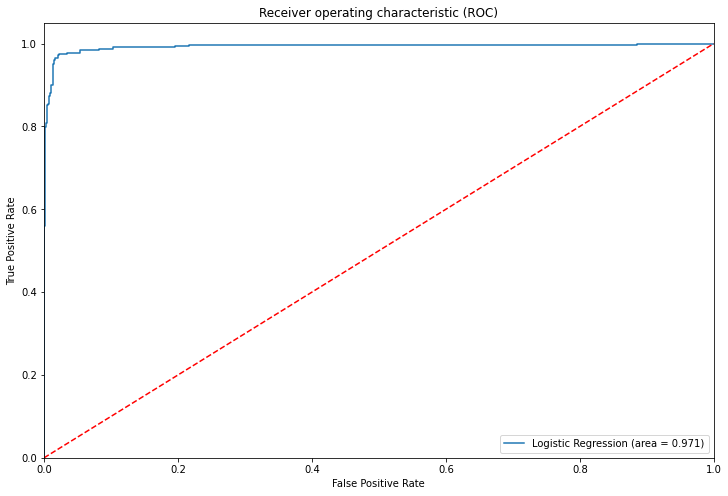

In [16]:
logit_roc_auc = roc_auc_score(y_test, lr.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(x_test)[:,1])
plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.3f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

Great! We have achieved an AUC of 0.971 and a curve close to that of an ideal classifier

# 4. Conclusions

The model based on the logistic regression that we have created has obtained an outstanding result in terms of accuracy and performance. The process followed is simple and can be implemented in real environments.

It should be taken into account that the model created only discriminates emails based on the words it contains. At no time is the subject, the from email address and its domain considered. Including these in the model, or combining it with another, could help improve the accuracy of the model and could be a future line of improvement